# Comparación de redes de co-ocurrencia dirigidas y con pesos


- Autor: Alen Figueroa

## Parte 1: Resumen

Hasta ahora, se han realizado análisis de lenguas mediante redes, pero limitadas a reconocer características de redes por si solas. De este modo, no se han reconocido propiedades que pueden ser generales para las lenguas. Sobre esta problemática, se propone realizar un análisis comparativo de redes linguísticas. Para esto, se construyen redes de palabras, dirigidas y con pesos, basados en informes de las naciones unidas.

La construcción de las redes se basa en lo siguiente: Los nodos son definidos sobre palabras que se mencionan en los artículos. Para las conexiones, un nodo A se dirige a un nodo B si existe una mención de la palabra A seguido de la palabra B en algun artículo de entrada. El peso en cada conexión está dado por la frecuencia en la que se repite dicha conexión.

Sobre estas redes, se analizan distintas características, como cantidad de componentes altamente conexas, cantidad de nodos vs cantidad de palabras en los artículos, propiedades small world y scale-free, entre otros.

Se concluyó que todas las redes tienen propiedades small-world y scale free. Además, en comparación, el inglés parece ser una lengua más flexible, por la densidad de su red. Por otro lado, se confirma la similaridad entre el francés y el español, producto a que son familias de lenguas.


## Parte 2: Experimentos

La idea es replicar, en primera instancia, los resultados del paper con la declaración de los derechos humanos.

Tenemos la declaración en 6 idiomas distintos: Inglés, español, ruso, francés, árabe y chino.

Para esto, se crean redes de palabras. Cada una de las redes son dirigidas y con pesos. Una palabra A se conecta a una palabra B si la palabra A le sigue la palabra B en alguna parte del texto. El peso es determinado por la frecuencia de esa sucesión en el artículo.

In [1]:
import networkx as nx
import numpy as np
!pip install jieba

import jieba


In [72]:
def construye_red(path):
    import re

    # Para quitar palabras que hagan mención a números
    p = re.compile('[0-9]')
    with open(path, encoding="utf-8") as f:

        # Quitamos los signos de puntuación y saltos de líneas.
        str_texto = f.read().replace("\n", " ").replace(";", "").replace(".", "").replace(",", "").replace(":", "") 
        texto = []
        palabras = []
        if path == "datos/udhr_cmn_hans.txt":
            texto = jieba.lcut(str_texto)
        else:
            # Eliminamos las palabras que tengan números.
            texto = [ s for s in str_texto.split() if not p.match(s) ]
            palabras = list(set(texto))

        # Creamos el grafo y le insertamos los nodos
        G = nx.DiGraph()
        for palabra in palabras:
            G.add_node(palabra)

        # Agregamos las aristas
        max = 0
        for i in range(len(texto)-1):

            # Si no existe la conexión, se crea e inicializa en 1
            if not G.has_edge(texto[i], texto[i+1]):
                G.add_edge(texto[i], texto[i+1], weight=1)
            
            # Si la conexión ya existe, se le agrega 1 al peso
            else:
                G[texto[i]][texto[i+1]]['weight'] = G[texto[i]][texto[i+1]]['weight'] + 1

                # Determinamos el peso máximo para luego normalizar los pesos
                if max < G[texto[i]][texto[i+1]]['weight']:
                    max = G[texto[i]][texto[i+1]]['weight']
        # Normalizamos los pesos
        #for edge in G.edges(data=True):
        #    edge[2]['weight'] = edge[2]['weight']/max 
        return G


# Creamos las redes de palabras de todos los textos
redes = {}
for valor in ["spa", "eng", "rus", "cmn_hans", "arb"]:
    redes[valor] = construye_red("datos/udhr_" + valor + '.txt')





In [73]:
import matplotlib.pyplot as plt


def graficar(key):
    plt.figure(3,figsize=(18,18)) 
    ax = plt.gca()
    ax.set_title(key)
    pos = nx.kamada_kawai_layout(redes[key])
    nx.draw(redes[key],pos, with_labels=False)
    #for p in pos:  # raise text positions
    #    pos[p][1] += 0.07
    #    nx.draw_networkx_labels(redes[key], pos)
    plt.show()

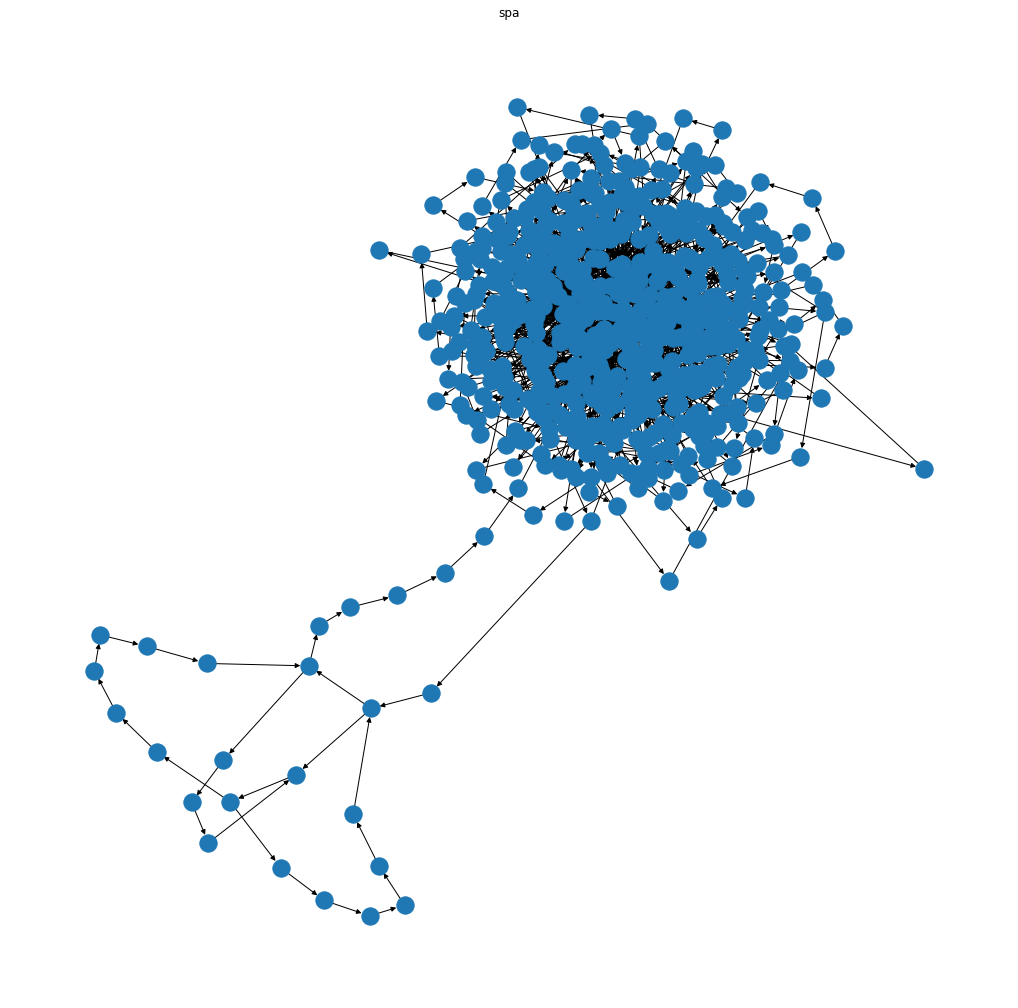

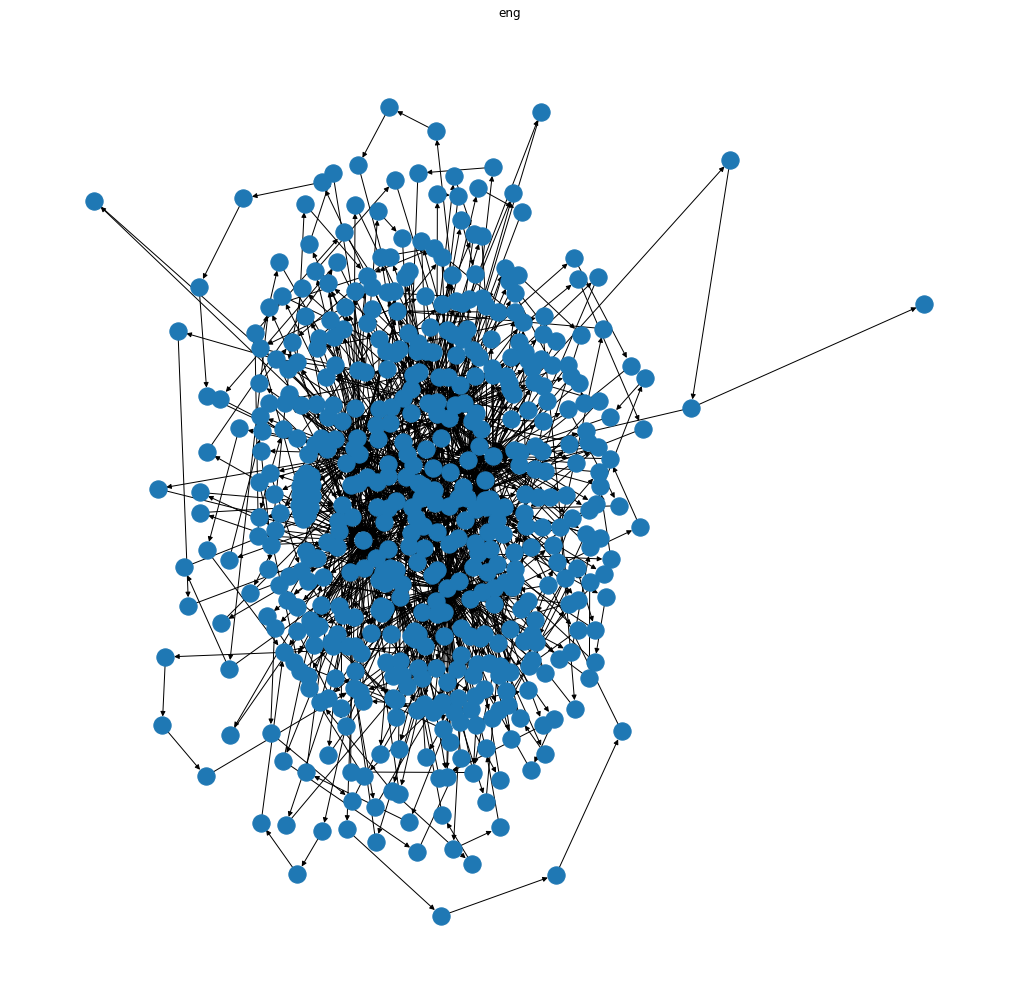

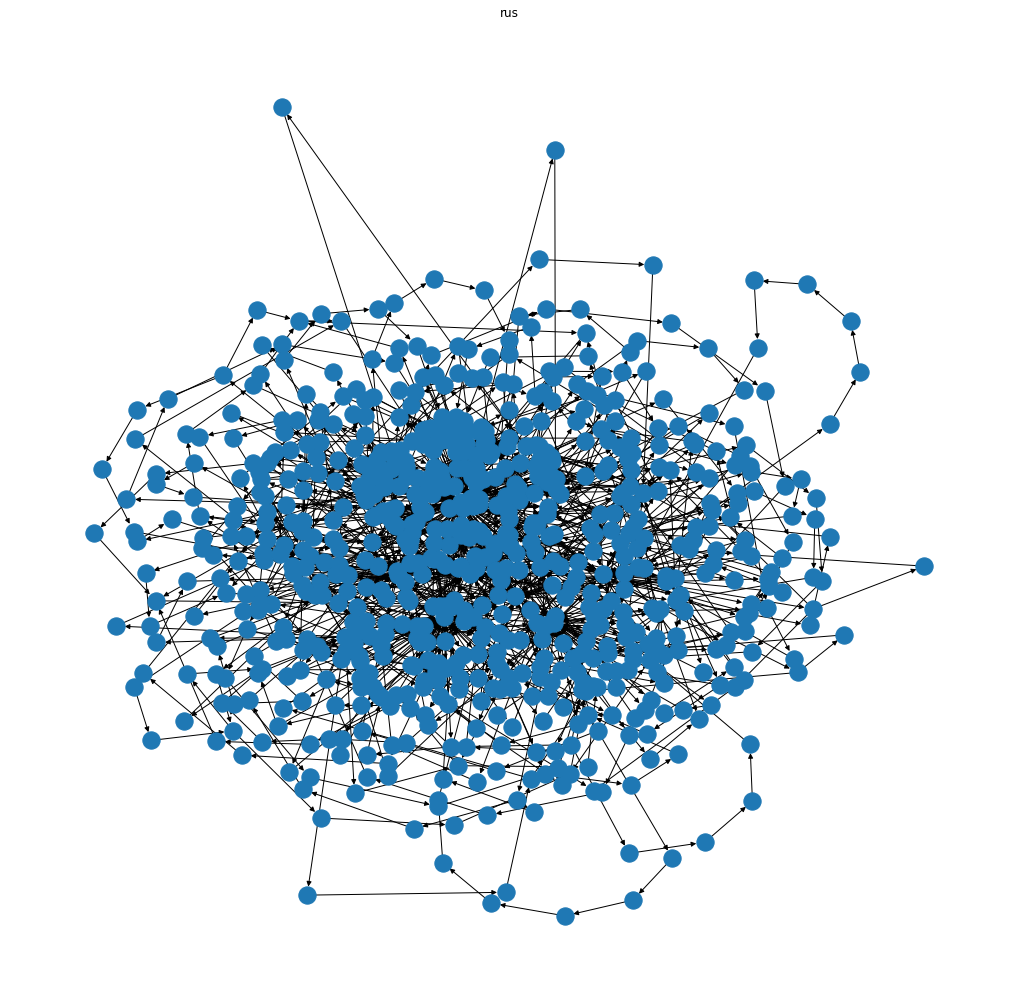

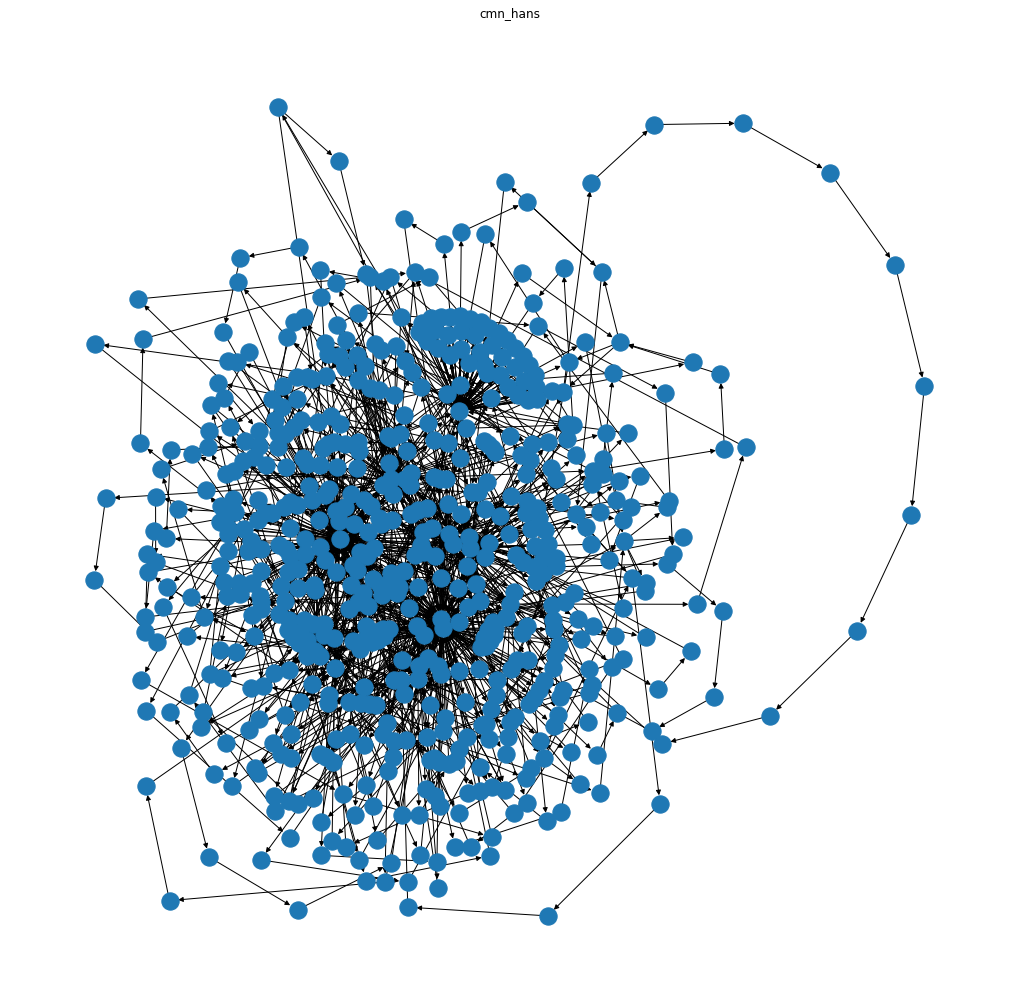

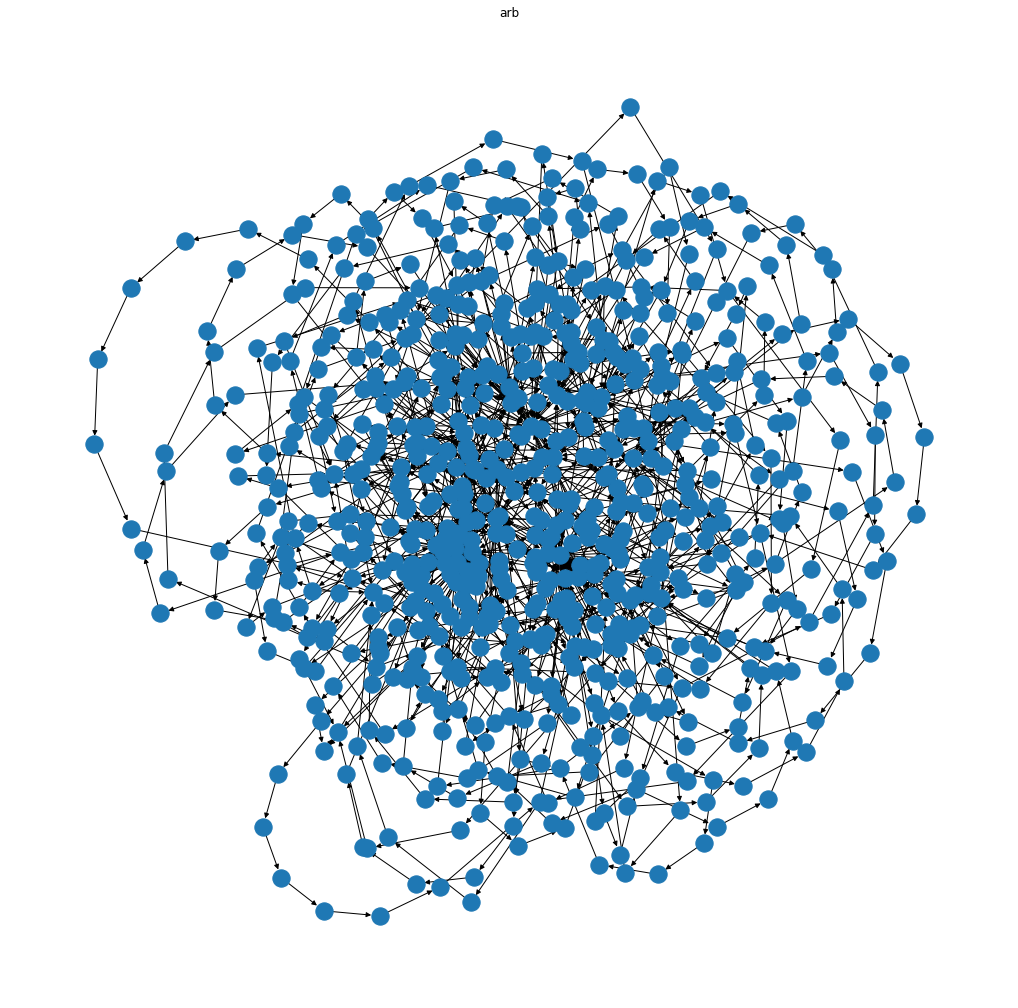

In [75]:
for valor in ["spa", "eng", "rus", "cmn_hans", "arb"]:
    graficar(valor)


In [76]:
datos = { key : {} for key in redes.keys() }
import numpy as np

for key in datos.keys():
    datos[key]["clustering"] = nx.average_clustering(redes[key], weight="weight")
    datos[key]["nodes"] = len(redes[key])
    datos[key]["edges"] = redes[key].number_of_edges()
    datos[key]["degree"] = np.array(list(nx.degree_centrality(redes[key]).values())).mean()

    datos[key]["in_degree"] = np.array(list(nx.in_degree_centrality(redes[key]).values())).mean()
    datos[key]["out_degree"] = np.array(list(nx.out_degree_centrality(redes[key]).values())).mean()


In [77]:
from IPython.display import HTML, display
import tabulate

tabla = [[key] + [datos[key][valor] for valor in datos[key].keys()] for key in datos.keys()]
display(HTML(tabulate.tabulate(tabla, tablefmt='html', stralign='center', headers=['', 'coef. clustering', 'nodos', 'aristas', 'grado', 'in_degree', 'out_degree'])))

Podemos visualizar varias cosas. Primero, la red en chino tiene un coeficiente de clustering más bajo, lo que puede ser consecuencia de la dificultad al separar las palabras. Esto último es debido a que se separan de manera más contextual que otras lenguas, como el inglés, que utilizan estructuras determinadas como los espacios.

Otra cosa que podemos visualizar es que en el gráfico del inglés existen menos caminos separados, a diferencia del ruso o árabe, que tienen los lados extremos de la red mostrando una gran cantidad de caminos de pocos grados.

In [123]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
nltk.download('wordnet')
def construye_red_sin_stopwords(path, idioma, lematiza):
    import re

    # Para quitar palabras que hagan mención a números
    p = re.compile('[0-9]')
    with open(path, encoding="utf-8") as f:

        # Quitamos los signos de puntuación y saltos de líneas.
        str_texto = f.read().replace("\n", " ").replace(";", "").replace(".", "").replace(",", "").replace(":", "") 
        texto = []
        palabras = []
        if path == "datos/udhr_cmn_hans.txt":
            texto = jieba.lcut(str_texto)
        else:
            # Eliminamos las palabras que tengan números.
            texto = [ s for s in str_texto.split() if not p.match(s) ]
            palabras = list(set(texto))
        stop_words = set(stopwords.words(idioma)) 
        palabras = [ (lemmatizer.lemmatize(w) if lematiza else w) for w in palabras if not w in  stop_words]
        texto = [ (lemmatizer.lemmatize(w) if lematiza else w) for w in texto if not w in  stop_words]
        # Creamos el grafo y le insertamos los nodos
        G = nx.DiGraph()
        for palabra in palabras:
            G.add_node(palabra)

        # Agregamos las aristas
        max = 0
        for i in range(len(texto)-1):

            # Si no existe la conexión, se crea e inicializa en 1
            if not G.has_edge(texto[i], texto[i+1]):
                G.add_edge(texto[i], texto[i+1], weight=1)
            
            # Si la conexión ya existe, se le agrega 1 al peso
            else:
                G[texto[i]][texto[i+1]]['weight'] = G[texto[i]][texto[i+1]]['weight'] + 1

                # Determinamos el peso máximo para luego normalizar los pesos
                if max < G[texto[i]][texto[i+1]]['weight']:
                    max = G[texto[i]][texto[i+1]]['weight']
        # Normalizamos los pesos
        #for edge in G.edges(data=True):
        #    edge[2]['weight'] = edge[2]['weight']/max 
        return G

red2 = construye_red_sin_stopwords("datos/udhr_eng.txt", 'english', True)
red3 = construye_red_sin_stopwords("datos/udhr_eng.txt", 'english', False)
redes['eng_filtrado'] = red2
redes['eng_lematizado'] = red3


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alenf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [130]:
datos2 = { key : {} for key in redes.keys() }

for key in datos2.keys():
    Gc = max(nx.strongly_connected_component_subgraphs(redes[key]), key=len)
    datos2[key]['shortest_path'] = nx.average_shortest_path_length(Gc)
    datos2[key]['diameter'] = nx.distance_measures.diameter(Gc)
    datos2[key]['cluster'] = nx.average_clustering(Gc)



### Análisis del paper + Propio

Lo que primero se realiza es un análisis de la componente más conexa de cada una de las redes. Sobre esta, se realizarán análisis de los caminos más cortos, el diámetro de la red y el coeficiente de clustering.
Además, realizaré el mismo análisis realizando 2 preprocesados: Eliminando stop words de la red y aplicando lemmatización en estos.

Para los preprocesados, se harán en las redes de inglés y español, debido a que están definidas en estas lenguas y son las que parecen más "fuertes" en cuanto a coeficiente de clustering y caminos cortos.

Cabe destacar que el coeficiente de clustering se realiza sin tener en cuenta los pesos de la red. Esto debido a que existe un sesgo propio de la  estructura de los textos, donde las palabras como "artículo" son outliers que se repiten demasiadas veces a lo largo del texto, modificando los coeficientes y los promedios.

In [131]:
tabla2 = [[key] + [datos2[key][valor] for valor in datos2[key].keys()] for key in datos2.keys()]
display(HTML(tabulate.tabulate(tabla2, tablefmt='html', stralign='center', headers=['', 'shortest path', 'diameter', 'cluster'])))

Se puede ver que, en el caso del inglés, los caminos cortos son bastante menores al diámetro, y además contiene el coeficiente de clustering más alto. Esto nos puede llevar a concluir de que las palabras del idioma inglés tienen más posibilidades, lo que lo hace un idioma más "poderoso" a la hora de generar textos, ya que se tiene un vocabulario más reducido que puede abarcar más ideas, a diferencia de otros.

También podemos ver el efecto de las stopwords en las redes de inglés y español. Podemos apreciar que el camino más corto aumenta, al igual que el diámetro y el coeficiente de cluster. Esto podemos explicarlo porque nos deshacemos de la ambiguedad de la palabra, ya que por esta propiedad se comportan como palabras puente entre comunidades de la red.